<a href="https://colab.research.google.com/github/GreatGeorge-007/AI-for-Football-Analysis/blob/main/Dissertation_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Dissertation Notebook – AI‑Powered Plant Health Diagnosis (Tomato & Pepper)
This notebook accompanies the dissertation *AI‑Powered Plant Health Diagnosis using Leaf Images* and provides a **reproducible pipeline**:

- Data loading and preprocessing (PlantVillage subset – tomato & pepper)
- Model: MobileNetV2 (transfer learning + fine‑tuning)
- Training and evaluation (accuracy, precision, recall, F1, confusion matrix)
- Optional: Streamlit diagnostic UI + advisory prototype

## How to run locally
1. Create a Python 3.10+ environment and install requirements:
   ```bash
   pip install -r requirements.txt
   ```
2. Update dataset paths in **Data Loading & Description**.
3. Run the notebook top‑to‑bottom.
4. (Optional) Launch Streamlit:
   ```bash
   streamlit run streamlit_app.py
   ```

> Cleaned for submission: non‑working/error cells removed; outputs cleared for reproducibility.


# Step 1: Install Dependencies

# 📦 Setup & Imports

In [ ]:
# Step 1: Install Dependencies
!pip install tensorflow opencv-python matplotlib scikit-learn --quiet



# Step 2: Mount Drive

In [ ]:
# Step 2: Mount Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Set dataset path
import os

base_dir = '/content/drive/MyDrive/DISERTATION/PlantVillage'
data_dir = '/content/drive/MyDrive/DISERTATION/PlantVillage'



# 📁 Data Loading & Description

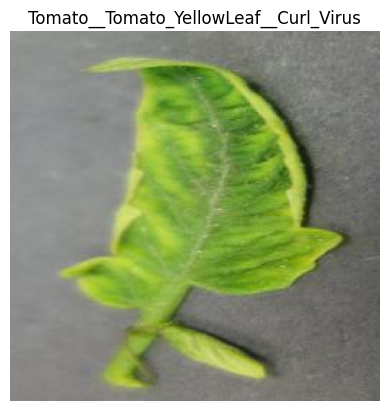

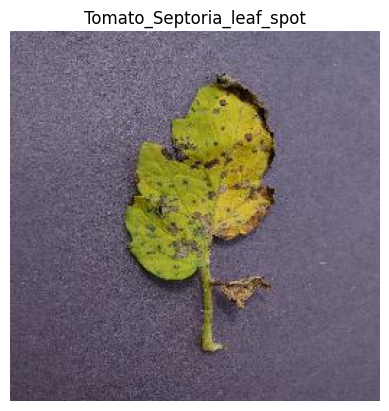

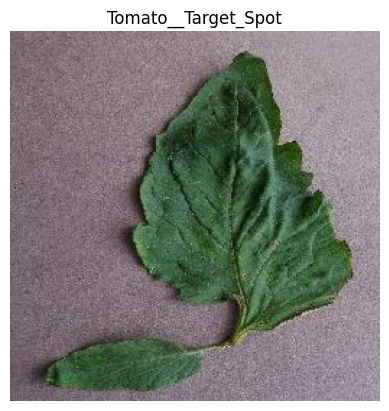

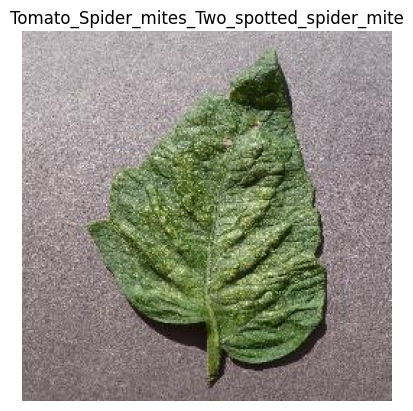

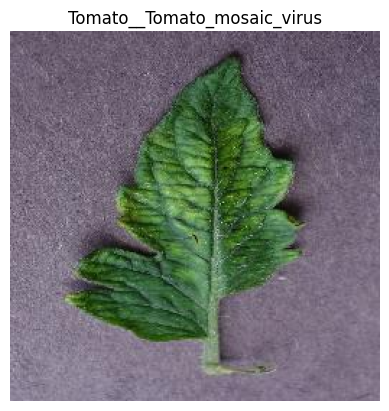

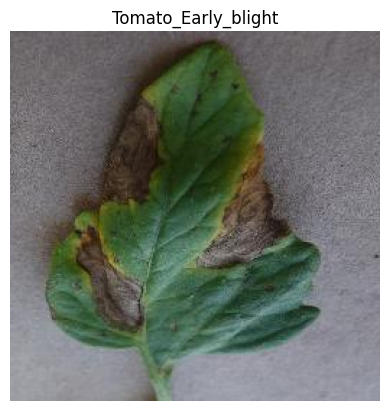

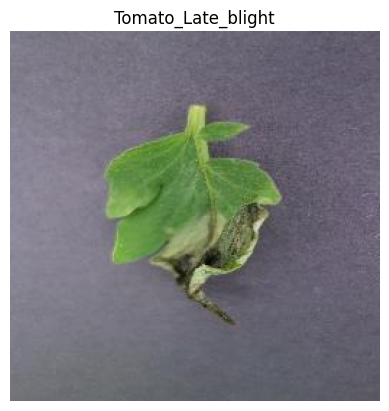

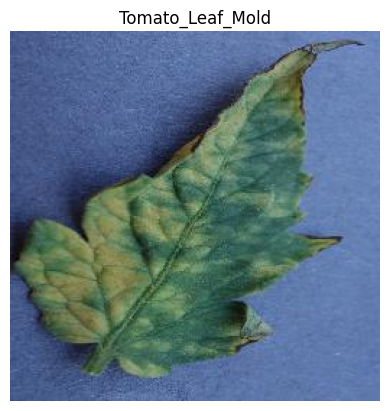

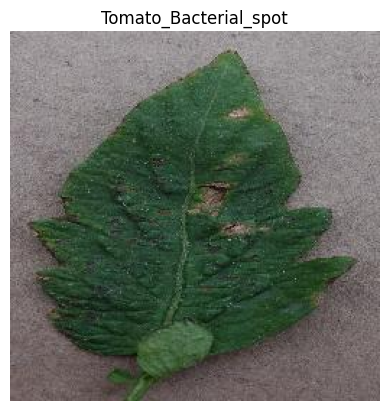

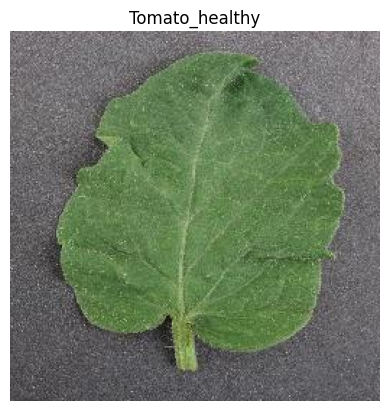

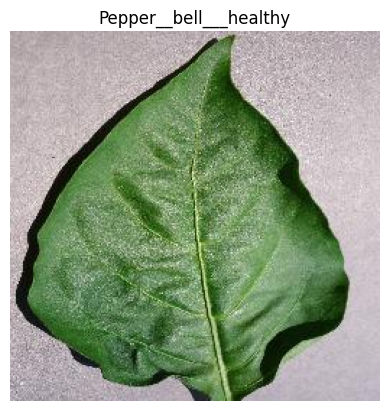

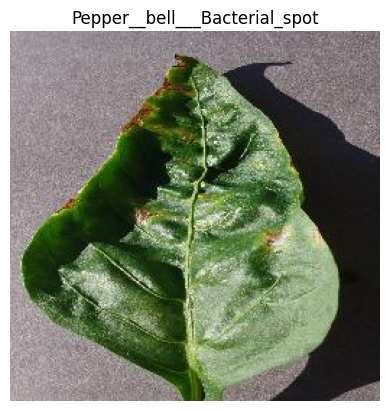

In [ ]:
# Cell: see section header above for context
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob

# Your root directory for the dataset
data_dir = '//content/drive/MyDrive/DISERTATION/PlantVillage'

# Only include Tomato and Pepper classes
classes = [cls for cls in os.listdir(data_dir) if 'Tomato' in cls or 'Pepper' in cls]

# Display one image from each selected class
for cls in classes:
    img_files = glob(f"{data_dir}/{cls}/*")
    if not img_files:
        print(f"Skipping {cls} — No images found.")
        continue

    img_path = img_files[0]  # Get first image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Unable to load image for {cls}, skipping.")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
    plt.show()



In [ ]:
# Cell: see section header above for context
import shutil
import os

filtered_data_dir = '/content/tomato_pepper_data'

# Remove existing folder if it exists
if os.path.exists(filtered_data_dir):
    shutil.rmtree(filtered_data_dir)

os.makedirs(filtered_data_dir)

# Now copy only Tomato and Pepper folders
for cls in os.listdir(base_dir):
    if 'Tomato' in cls or 'Pepper' in cls:
        src = os.path.join(base_dir, cls)
        dst = os.path.join(filtered_data_dir, cls)
        shutil.copytree(src, dst)


# 🧹 Preprocessing & Augmentation

In [ ]:
# Cell: see section header above for context
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation setup
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

# Training Data Generator
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation Data Generator
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


In [ ]:
# Cell: see section header above for context
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image settings
img_size = (224, 224)
batch_size = 32

# Create ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% for validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    '/content/tomato_pepper_data',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data
val_generator = train_datagen.flow_from_directory(
    '/content/tomato_pepper_data',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


 Set Up Data Generators

In [ ]:
# Cell: see section header above for context
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image size and batch size
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/content/tomato_pepper_data',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/content/tomato_pepper_data',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Load MobileNetV2 (without top classifier layer)

# 🧠 Model: MobileNetV2 (Transfer Learning)

In [ ]:
# Cell: see section header above for context
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base model for now


Add Custom Layers

In [ ]:
# Cell: see section header above for context
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


Compile the Model

# ⚙️ Training Configuration

In [ ]:
# Cell: see section header above for context
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Train the Model

# Train Model

In [ ]:
# Cell: see section header above for context
from tensorflow.keras.callbacks import ModelCheckpoint

# ✅ Path to save the best model in Google Drive
model_path = '/content/drive/MyDrive/DISERTATION/plant_health_model.keras'

# Callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    model_path,             # Save path
    monitor='val_accuracy', # Metric to monitor
    save_best_only=True,    # Only save when val_accuracy improves
    mode='max',
    verbose=1
)

# Train and save best model automatically to Google Drive
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1,
    callbacks=[checkpoint]
)

# Save final model after training (optional backup)
model.save('/content/drive/MyDrive/DISERTATION/plant_health_model_final.keras')


In [ ]:
# Cell: see section header above for context
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 🔍 Error Analysis (Confusion Matrix)

In [ ]:
# Cell: see section header above for context
import numpy as np
from tensorflow.keras.preprocessing import image

# Get a random image from validation set
val_batch, val_labels = next(val_generator)
sample_img = val_batch[0]
sample_label = val_labels[0]

# Predict
pred = model.predict(np.expand_dims(sample_img, axis=0))
pred_class = np.argmax(pred)
true_class = np.argmax(sample_label)

# Decode class indices
class_indices = {v: k for k, v in train_generator.class_indices.items()}
predicted_label = class_indices[pred_class]
true_label = class_indices[true_class]

# Show image with prediction
plt.imshow(sample_img)
plt.title(f"Predicted: {predicted_label} | True: {true_label}")
plt.axis('off')
plt.show()


CONFUSION MATRIX

# 📊 Evaluation & Metrics

In [ ]:
# Cell: see section header above for context
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np


In [ ]:
# Reset generator and predict on validation data
val_generator.reset()
Y_pred = model.predict(val_generator, steps=val_generator.samples // val_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)


In [ ]:
# Cell: see section header above for context
y_true = val_generator.classes


In [ ]:
# Cell: see section header above for context
cm = confusion_matrix(y_true, y_pred)


In [ ]:
# Cell: see section header above for context
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
# Cell: see section header above for context
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))


Improve acuracy

In [ ]:
# Cell: see section header above for context
import os

base_dir = "/content/drive/MyDrive/DISERTATION"

for root, dirs, files in os.walk(base_dir):
    for d in dirs:
        print(os.path.join(root, d))


In [ ]:
# Cell: see section header above for context
import os
import shutil
import random

# Paths
base_dir = "/content/drive/MyDrive/DISERTATION/PlantVillage/PlantVillage"
output_dir = "/content/tomato_pepper_split"

# Classes you want to keep
classes_to_keep = [
    "Tomato__Tomato_YellowLeaf__Curl_Virus",
    "Tomato_Septoria_leaf_spot",
    "Tomato__Target_Spot",
    "Tomato_Spider_mites_Two_spotted_spider_mite",
    "Tomato__Tomato_mosaic_virus",
    "Tomato_Early_blight",
    "Tomato_Late_blight",
    "Tomato_Leaf_Mold",
    "Tomato_Bacterial_spot",
    "Tomato_healthy",
    "Pepper__bell___healthy",
    "Pepper__bell___Bacterial_spot"
]

# Train/Val split ratio
split_ratio = 0.8

# Create train and val folders
for split in ['train', 'val']:
    split_path = os.path.join(output_dir, split)
    os.makedirs(split_path, exist_ok=True)
    for cls in classes_to_keep:
        os.makedirs(os.path.join(split_path, cls), exist_ok=True)

# Split files
for cls in classes_to_keep:
    class_path = os.path.join(base_dir, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    split_point = int(len(images) * split_ratio)
    train_imgs = images[:split_point]
    val_imgs = images[split_point:]

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, 'train', cls))

    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, 'val', cls))

print("✅ Dataset split into train and val sets at:", output_dir)


# 💾 Save/Load Model

In [ ]:
# Cell: see section header above for context
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/DISERTATION/plant_health_model_final.keras')

# Check the model summary
model.summary()


In [ ]:
# Cell: see section header above for context
import os

train_dir = "/content/tomato_pepper_split/train"
val_dir = "/content/tomato_pepper_split/val"

print("Train directory exists:", os.path.exists(train_dir))
print("Validation directory exists:", os.path.exists(val_dir))

if os.path.exists(train_dir):
    print("Train classes:", os.listdir(train_dir))
if os.path.exists(val_dir):
    print("Validation classes:", os.listdir(val_dir))


In [ ]:
# Cell: see section header above for context
import os
import shutil
from sklearn.model_selection import train_test_split
from google.colab import drive

# 1️⃣ Mount Google Drive
drive.mount('/content/drive')

# 2️⃣ Original dataset path
original_dataset_dir = '/content/drive/MyDrive/DISERTATION/PlantVillage'

# 3️⃣ Target split path (permanent storage)
split_dir = '/content/drive/MyDrive/DISERTATION/tomato_pepper_split'
train_dir = os.path.join(split_dir, 'train')
val_dir = os.path.join(split_dir, 'val')

# 4️⃣ Create train/val folders
for folder in [train_dir, val_dir]:
    os.makedirs(folder, exist_ok=True)

# 5️⃣ Select only tomato and pepper classes
selected_classes = [
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato_Septoria_leaf_spot',
    'Tomato__Target_Spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Bacterial_spot',
    'Tomato_healthy',
    'Pepper__bell___healthy',
    'Pepper__bell___Bacterial_spot'
]

# 6️⃣ Split and copy files
for cls in selected_classes:
    cls_dir = os.path.join(original_dataset_dir, cls)
    if not os.path.exists(cls_dir):
        print(f"Skipping {cls}, folder not found.")
        continue

    images = os.listdir(cls_dir)
    train_files, val_files = train_test_split(images, test_size=0.2, random_state=42)

    # Create class subfolders in train and val
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    # Copy training images
    for file in train_files:
        shutil.copy(os.path.join(cls_dir, file), os.path.join(train_dir, cls))

    # Copy validation images
    for file in val_files:
        shutil.copy(os.path.join(cls_dir, file), os.path.join(val_dir, cls))

print("✅ Dataset split complete!")
print(f"Train folder: {train_dir}")
print(f"Validation folder: {val_dir}")


In [ ]:
# Cell: see section header above for context
from google.colab import drive
drive.mount('/content/drive')

import os

# Check if the file exists
model_path = '/content/drive/MyDrive/DISERTATION'
print(os.listdir(model_path))



In [ ]:
# Cell: see section header above for context
from google.colab import drive
drive.mount('/content/drive')

import os
folder = '/content/drive/MyDrive/DISERTATION'
print(os.listdir(folder))



In [ ]:
# Cell: see section header above for context
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import os

model_path = '/content/drive/MyDrive/DISERTATION/plant_health_model_final.keras'

if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print("✅ Model loaded successfully.")
else:
    print("❌ Model file not found.")


In [ ]:
# Cell: see section header above for context
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/DISERTATION/tomato_pepper_split/train'
val_dir = '/content/drive/MyDrive/DISERTATION/tomato_pepper_split/val'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

In [ ]:
# Cell: see section header above for context
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # Fine-tune for a few more epochs
    verbose=1
)

# Save improved model
model.save('/content/drive/MyDrive/DISERTATION/plant_health_model_final_improved.keras')


In [ ]:
# Cell: see section header above for context
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


In [ ]:
# Cell: see section header above for context
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your validation data
val_dir = "/content/drive/MyDrive/DISERTATION/tomato_pepper_split/val"

# Data preprocessing
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

In [ ]:
# Cell: see section header above for context
from sklearn.metrics import classification_report, f1_score
import numpy as np

# === 1. Get predictions on validation set ===
val_generator.reset()  # ensure the generator starts from the beginning
pred_probs = model.predict(val_generator)  # probabilities
pred_classes = np.argmax(pred_probs, axis=1)  # predicted class indices

# === 2. True labels ===
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())  # class names

# === 3. F1 Score ===
f1 = f1_score(true_classes, pred_classes, average='weighted')  # weighted for class imbalance
print(f"Weighted F1 Score: {f1:.4f}")

# === 4. Full classification report ===
print(classification_report(true_classes, pred_classes, target_names=class_labels))


In [ ]:
# Cell: see section header above for context
val_dir = "/content/tomato_pepper_split/val"


In [ ]:
# Cell: see section header above for context
from sklearn.metrics import f1_score
# inside your training loop after model.fit


In [ ]:
# Cell: see section header above for context
from sklearn.metrics import classification_report, f1_score
import numpy as np

# === 1. Validation generator EXACTLY as in training ===
from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_dir = "/content/drive/MyDrive/DISERTATION/tomato_pepper_split/val"

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# === 2. Predictions ===
val_generator.reset()
pred_probs = model.predict(val_generator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_generator.classes

# === 3. F1 score & report ===
weighted_f1 = f1_score(true_classes, pred_classes, average='weighted')
print("Weighted F1 Score on Training Validation Set:", weighted_f1)

print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=val_generator.class_indices.keys()))

In [ ]:
# Cell: see section header above for context
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Ensure the generator is at the start
val_generator.reset()

# Get predictions
pred_probs = model.predict(val_generator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Improved Plant Health Model')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Optional: classification report
print(classification_report(true_classes, pred_classes, target_names=class_labels))


In [ ]:
# Cell: see section header above for context
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Paths (change if yours differ)
MODEL_PATH = "/content/drive/MyDrive/DISERTATION/plant_health_model_final_improved.keras"
VAL_DIR    = "/content/drive/MyDrive/DISERTATION/tomato_pepper_split/val"

# Load model (skip if already in memory)
try:
    _ = model.summary()
    print("Using model already in memory.")
except:
    print("Loading model from Drive...")
    model = tf.keras.models.load_model(MODEL_PATH)

# Validation generator (NO shuffle so indices & labels line up)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Class label helpers
idx2class = {v:k for k,v in val_generator.class_indices.items()}
class_names = [idx2class[i] for i in range(len(idx2class))]

In [ ]:
# Predict probabilities over the whole val set (one pass)
val_generator.reset()
pred_probs = model.predict(val_generator, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)

# True labels
true_labels = val_generator.classes

# Confidence of predicted class
confidences = pred_probs[np.arange(len(pred_probs)), pred_labels]

# Filepaths (to show original images)
filepaths = np.array(val_generator.filepaths)


In [ ]:
# Cell: see section header above for context
import matplotlib.pyplot as plt

def show_grid(indices, cols=4, figsize=(14, 12), title="Samples"):
    rows = int(np.ceil(len(indices) / cols))
    plt.figure(figsize=figsize)
    for i, idx in enumerate(indices[:rows*cols]):
        img = tf.keras.utils.load_img(filepaths[idx], target_size=(224, 224))
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        t = class_names[true_labels[idx]]
        p = class_names[pred_labels[idx]]
        conf = confidences[idx]
        color = "green" if t == p else "red"
        plt.title(f"T: {t}\nP: {p} ({conf:.2f})", color=color, fontsize=9)
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


In [ ]:
# Cell: see section header above for context
np.random.seed(42)
rand_idx = np.random.choice(len(filepaths), size=16, replace=False)
show_grid(rand_idx, title="Random validation samples: True vs Predicted")


In [ ]:
# Cell: see section header above for context
correct_mask = (pred_labels == true_labels)
correct_idx  = np.where(correct_mask)[0]
# Sort correct by confidence (desc)
top_correct  = correct_idx[np.argsort(confidences[correct_idx])[::-1]]

show_grid(top_correct[:16], title="Top correct predictions (highest confidence)")


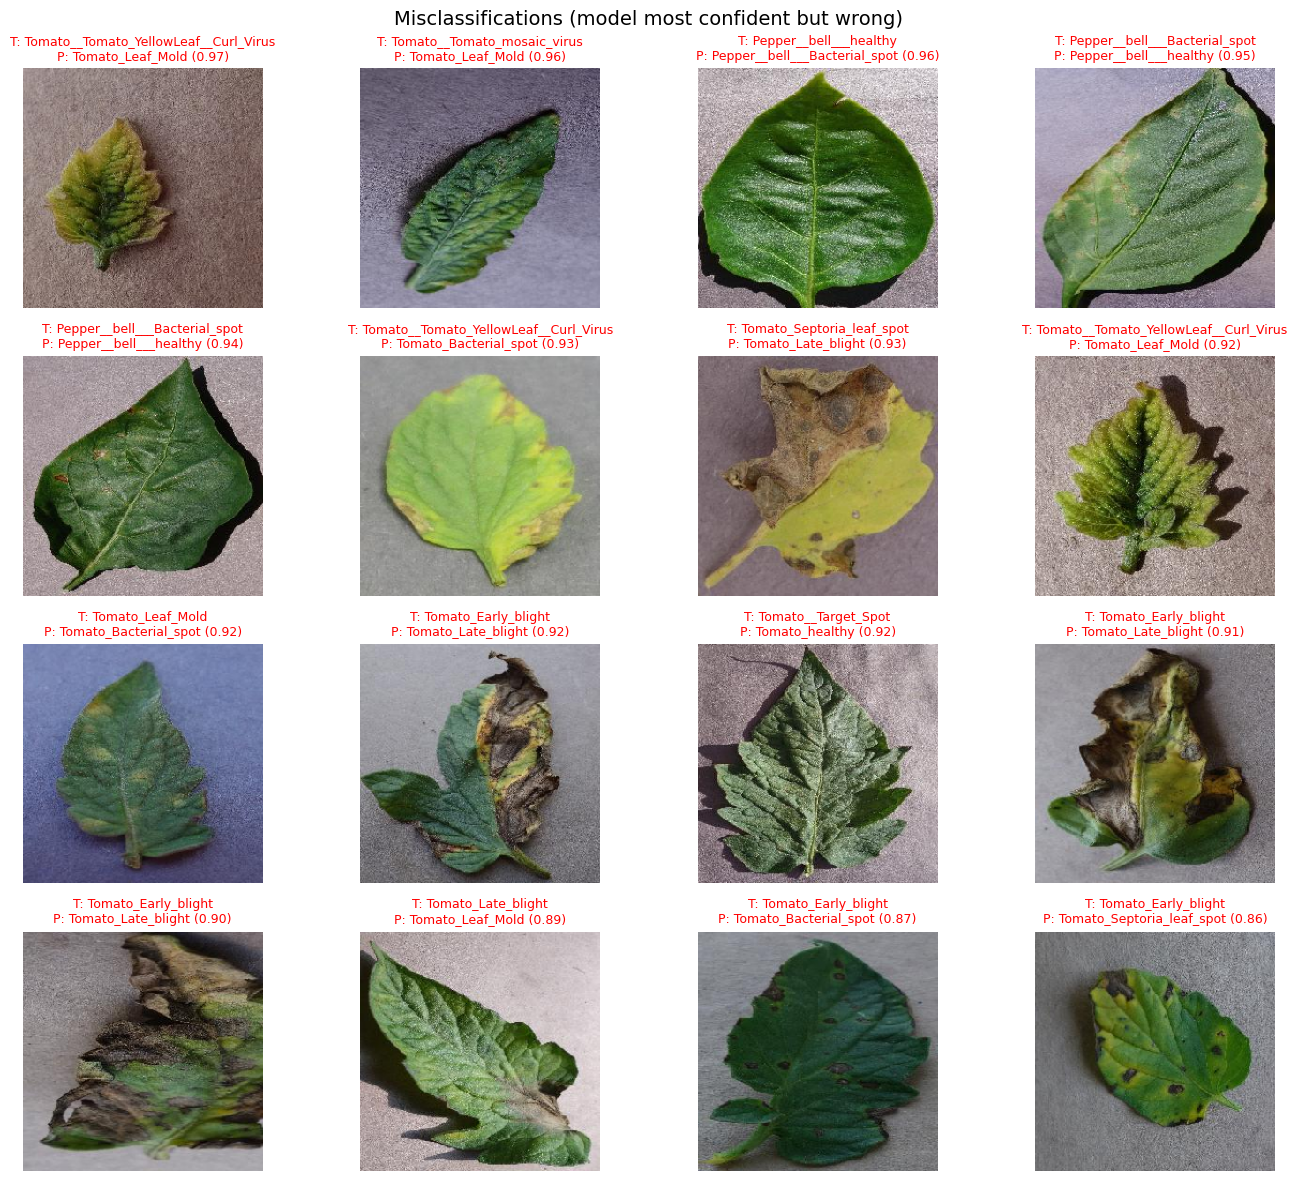

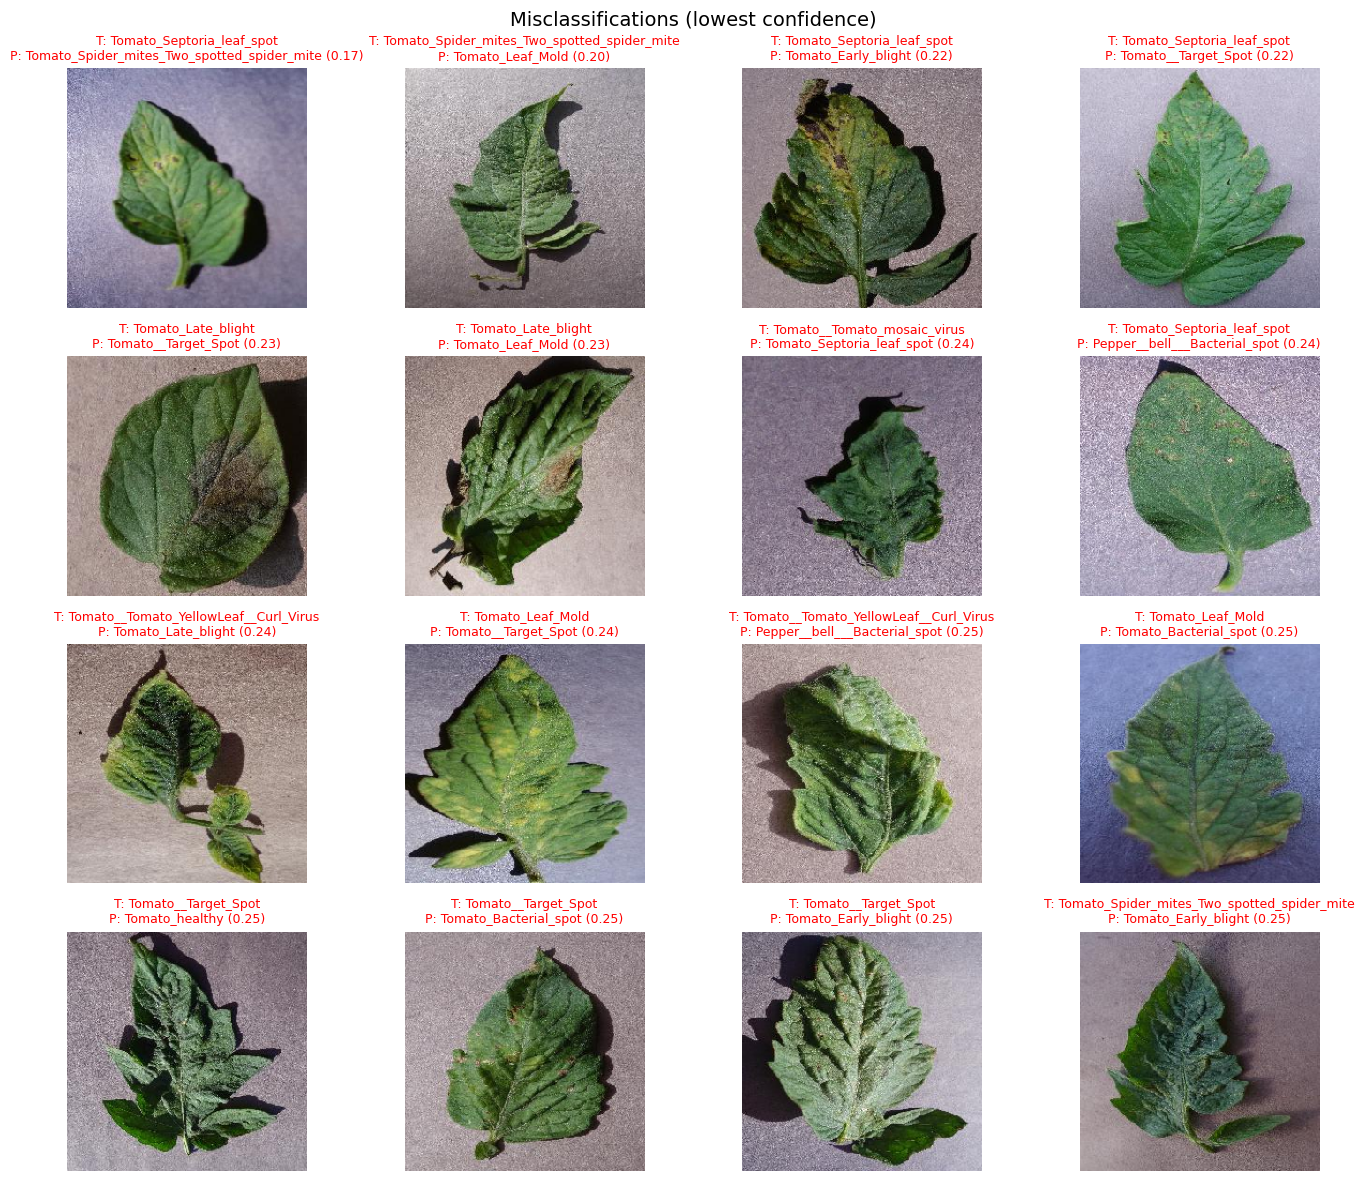

In [ ]:
# Cell: see section header above for context
wrong_mask = (pred_labels != true_labels)
wrong_idx  = np.where(wrong_mask)[0]

if len(wrong_idx) == 0:
    print("No misclassifications found 🎉")
else:
    # Sort wrong by confidence (desc) → strongest wrong beliefs first
    strongest_wrong = wrong_idx[np.argsort(confidences[wrong_idx])[::-1]]
    show_grid(strongest_wrong[:16], title="Misclassifications (model most confident but wrong)")

    # Also show uncertain ones (lowest confidence)
    uncertain_wrong = wrong_idx[np.argsort(confidences[wrong_idx])]
    show_grid(uncertain_wrong[:16], title="Misclassifications (lowest confidence)")


In [ ]:
# Cell: see section header above for context
import pandas as pd

df = pd.DataFrame({
    "filepath": filepaths,
    "true_idx": true_labels,
    "true_label": [class_names[i] for i in true_labels],
    "pred_idx": pred_labels,
    "pred_label": [class_names[i] for i in pred_labels],
    "confidence": confidences
})

csv_path = "/content/drive/MyDrive/DISERTATION/val_predictions_with_confidence.csv"
df.to_csv(csv_path, index=False)
print(f"Saved predictions to: {csv_path}")


In [ ]:
# Cell: see section header above for context
import os, getpass
os.environ["OPENAI_API_KEY"] = getpass.getpass("Paste your OpenAI API key (hidden): ")


In [ ]:
# Cell: see section header above for context
import os, json
from openai import OpenAI

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Fallback static tips (used if API fails)
fallback = {
    "Pepper__bell___Bacterial_spot": "Remove infected leaves; avoid overhead watering; apply copper fungicide.",
    "Tomato_Bacterial_spot": "Prune infected leaves; disinfect tools; spray copper weekly.",
    "Tomato_Early_blight": "Remove diseased leaves; rotate crops; apply chlorothalonil fungicide.",
    "Tomato_Late_blight": "Remove & destroy plants; avoid leaf wetness; use mancozeb.",
    "Tomato_Leaf_Mold": "Improve airflow; lower humidity; spray chlorothalonil/mancozeb.",
    "Tomato_Septoria_leaf_spot": "Prune lower leaves; rotate crops; apply copper/chlorothalonil.",
    "Tomato_Spider_mites_Two_spotted_spider_mite": "Blast with water; use insecticidal soap or neem oil.",
    "Tomato__Target_Spot": "Remove affected leaves; keep foliage dry; apply chlorothalonil.",
    "Tomato__Tomato_YellowLeaf__Curl_Virus": "Remove plants; control whiteflies; use resistant varieties.",
    "Tomato__Tomato_mosaic_virus": "Remove plants; disinfect tools; avoid tobacco residue.",
    "Nitrogen_Deficiency": "Apply nitrogen fertiliser (urea/compost); water evenly."
}

def llm_advice(diagnosis: str, confidence: float = None, crop: str = "Tomato"):
    """
    Returns concise advice JSON using OpenAI (2–3 short steps + safety).
    Falls back to static mapping if the API isn’t available.
    """
    try:
        system = (
            "You are an agronomy advisor. Return very concise, practical steps "
            "for smallholder farmers. Use plain language. 2–3 short steps max "
            "and one safety line. Total ≤ 35 words. JSON only: "
            '{"diagnosis":"...", "advice":["step1","step2","step3"], "safety":"..."}'
        )
        user = {
            "diagnosis": diagnosis,
            "crop": crop,
            "confidence": confidence
        }
        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            temperature=0.3,
            messages=[
                {"role":"system","content":system},
                {"role":"user","content":json.dumps(user)}
            ]
        )
        content = resp.choices[0].message.content
        return json.loads(content)  # Expecting strict JSON per system prompt
    except Exception as e:
        # Fallback to static advice if the LLM fails
        tip = fallback.get(diagnosis, "Consult local agronomy officer for targeted treatment.")
        return {"diagnosis": diagnosis, "advice": [tip], "safety": "Follow label directions; wear PPE."}


In [ ]:
# ===============================
# 0) Mount Drive + imports
# ===============================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, json, numpy as np, tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ===============================
# 1) Config: paths + API key
# ===============================
# 🔑 Set your OpenAI API key safely for this session
# (Optional: use getpass to avoid printing to screen)
# import getpass, os
# os.environ["OPENAI_API_KEY"] = getpass.getpass("Paste OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = "sk-REPLACE_ME"   # <-- replace with your key, or use getpass above

BASE_DIR = "/content/drive/MyDrive/DISERTATION"
VAL_DIR  = os.path.join(BASE_DIR, "tomato_pepper_split", "val")
MODEL_PATH = os.path.join(BASE_DIR, "plant_health_model_final_improved.keras")  # change if different

# Sanity checks
assert os.path.exists(VAL_DIR), f"Validation folder not found: {VAL_DIR}"
assert os.path.exists(MODEL_PATH), f"Model file not found: {MODEL_PATH}"

# ===============================
# 2) Load model + validation data
# ===============================
print("Loading model...")
model = tf.keras.models.load_model(MODEL_PATH)

print("Preparing validation generator...")
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

idx2class = {v:k for k,v in val_gen.class_indices.items()}
class_names = [idx2class[i] for i in range(len(idx2class))]

# ===============================
# 3) LLM advisor (short, practical)
# ===============================
from openai import OpenAI
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Fallback static tips if API fails/unavailable
fallback = {
    "Pepper__bell___Bacterial_spot": "Remove infected leaves; avoid overhead watering; apply copper fungicide.",
    "Tomato_Bacterial_spot": "Prune infected leaves; disinfect tools; spray copper weekly.",
    "Tomato_Early_blight": "Remove diseased leaves; rotate crops; apply chlorothalonil.",
    "Tomato_Late_blight": "Destroy infected plants; avoid leaf wetness; use mancozeb.",
    "Tomato_Leaf_Mold": "Improve airflow; reduce humidity; spray chlorothalonil/mancozeb.",
    "Tomato_Septoria_leaf_spot": "Prune lower leaves; rotate crops; copper/chlorothalonil spray.",
    "Tomato_Spider_mites_Two_spotted_spider_mite": "Blast with water; use insecticidal soap or neem.",
    "Tomato__Target_Spot": "Remove affected leaves; keep foliage dry; chlorothalonil spray.",
    "Tomato__Tomato_YellowLeaf__Curl_Virus": "Remove plants; control whiteflies; resistant varieties.",
    "Tomato__Tomato_mosaic_virus": "Remove plants; disinfect tools; avoid tobacco residue.",
    "Nitrogen_Deficiency": "Apply nitrogen fertiliser (urea/compost); water evenly."
}

def llm_advice(diagnosis: str, confidence: float = None, crop: str = "Tomato"):
    """
    Returns concise JSON advice using OpenAI. Falls back to static advice on error.
    Output: {"diagnosis":"...", "advice":[...], "safety":"..."}
    """
    try:
        system = (
            "You are an agronomy advisor. Return very concise, practical steps "
            "for smallholder farmers. Use plain language. 2–3 short steps max "
            "and one safety line. Total ≤ 35 words. JSON only: "
            '{"diagnosis":"...", "advice":["step1","step2","step3"], "safety":"..."}'
        )
        user = {"diagnosis": diagnosis, "crop": crop, "confidence": confidence}
        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            temperature=0.3,
            messages=[
                {"role":"system","content":system},
                {"role":"user","content":json.dumps(user)}
            ]
        )
        content = resp.choices[0].message.content
        return json.loads(content)
    except Exception as e:
        # Fallback if the API key is missing / rate-limited / offline
        tip = fallback.get(diagnosis, "Consult local extension officer for specific treatment.")
        return {"diagnosis": diagnosis, "advice": [tip], "safety": "Follow label directions; wear PPE."}

# ===============================
# 4) Predict a small batch + advise
# ===============================
print("Predicting a small batch and generating advice...")
batch_x, batch_y = next(val_gen)  # 16 random images from val (since shuffle=False, it's first 16)
probs = model.predict(batch_x, verbose=0)
pred_idx = np.argmax(probs, axis=1)
true_idx = np.argmax(batch_y, axis=1)

for i in range(len(pred_idx)):
    pred_label = class_names[pred_idx[i]]
    true_label = class_names[true_idx[i]]
    conf = float(probs[i, pred_idx[i]])

    print("\n==============================")
    print(f"True: {true_label} | Pred: {pred_label} (conf {conf:.2f})")

    if "healthy" in pred_label.lower():
        print("Advice: Plant appears healthy — maintain balanced fertiliser and steady irrigation.")
        print("Safety: Monitor weekly for new symptoms.")
    else:
        advice = llm_advice(pred_label, conf, crop="Tomato")
        print("Advice:", " ".join(advice.get("advice", [])))
        print("Safety:", advice.get("safety"))


In [ ]:
# Cell: see section header above for context
import os
print("OPENAI_API_KEY set:", os.environ.get("OPENAI_API_KEY")[:5] + "*****")


In [ ]:
# Cell: see section header above for context
from openai import OpenAI
import os

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

try:
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role":"user","content":"Say hello in 3 words"}],
        max_tokens=10
    )
    print("LLM Response:", resp.choices[0].message.content)
except Exception as e:
    print("Error:", e)


In [ ]:
# Cell: see section header above for context
import os, getpass
os.environ["OPENAI_API_KEY"] = getpass.getpass("Paste your OpenAI API key (hidden): ")


In [ ]:
# Cell: see section header above for context
from openai import OpenAI
import os

print("Key prefix:", (os.environ.get("OPENAI_API_KEY") or "")[:5] + "*****")
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

try:
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role":"user","content":"Say hello in 3 words"}],
        max_tokens=10,
        temperature=0.2
    )
    print("LLM OK ->", resp.choices[0].message.content)
except Exception as e:
    print("LLM ERROR ->", e)


In [ ]:
# Cell: see section header above for context
import os, requests

api_key = os.environ.get("OPENAI_API_KEY")
headers = {"Authorization": f"Bearer {api_key}"}

try:
    r = requests.get("https://api.openai.com/v1/models", headers=headers, timeout=15)
    print("Status:", r.status_code)
    print("OK -> API reachable" if r.status_code in (200, 401, 403) else r.text[:300])
except Exception as e:
    print("Connectivity problem:", e)


In [ ]:
# Cell: see section header above for context
import os, getpass

# Paste key safely; .strip() removes trailing spaces/newlines
raw_key = getpass.getpass("Paste your OpenAI API key (hidden): ").strip()

# Optional: quick sanity check (don’t print full key)
print("Key prefix:", raw_key[:8] + "*****", "| length:", len(raw_key))

# Reset the env var to the cleaned key
os.environ.pop("OPENAI_API_KEY", None)  # remove any old value
os.environ["OPENAI_API_KEY"] = raw_key


In [ ]:
# Cell: see section header above for context
from openai import OpenAI
import os, requests

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"], timeout=20.0)

# Low-level connectivity sanity check (should be 200/401/403, not a connection error)
try:
    r = requests.get(
        "https://api.openai.com/v1/models",
        headers={"Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}"},
        timeout=15
    )
    print("Models endpoint status:", r.status_code)
except Exception as e:
    print("Connectivity problem:", e)

# Minimal chat test
try:
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": "Say hello in 3 words"}],
        max_tokens=10,
        temperature=0.2
    )
    print("LLM OK ->", resp.choices[0].message.content)
except Exception as e:
    print("LLM ERROR ->", e)


In [ ]:
# Cell: see section header above for context
import openai
import time

# Your static advisory fallback
static_advice = {
    "Pepper__bell___Bacterial_spot": "Remove infected leaves; avoid overhead watering; apply copper fungicide.",
    "Pepper__bell___healthy": "Plant is healthy. Maintain balanced fertiliser and steady irrigation.",
    "Tomato_Bacterial_spot": "Remove infected leaves; apply copper-based spray; rotate crops.",
    "Tomato_Late_blight": "Use fungicides; avoid water on leaves; remove infected plants immediately.",
    "Tomato_Early_blight": "Use fungicide sprays; rotate crops; remove infected debris.",
    "Tomato_Leaf_Mold": "Ensure good air circulation; apply fungicide if severe.",
    "Tomato_Septoria_leaf_spot": "Remove affected leaves; apply protective fungicide.",
    "Tomato_Spider_mites_Two_spotted_spider_mite": "Spray miticide or neem oil; maintain humidity.",
    "Tomato__Target_Spot": "Apply fungicide; avoid dense planting.",
    "Tomato__Tomato_YellowLeaf__Curl_Virus": "Control whiteflies; remove infected plants; use resistant varieties.",
    "Tomato__Tomato_mosaic_virus": "Remove infected plants; disinfect tools; use resistant seeds.",
    "Tomato_healthy": "Plant is healthy. Continue monitoring and regular care."
}

def get_advice_from_llm(disease_name, location="farmer's region"):
    """
    Get advice from LLM. If quota exceeded or error occurs, fallback to static dictionary.
    """
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are an agricultural advisor."},
                {"role": "user", "content": f"A farmer has {disease_name}. "
                                             f"Generate short, practical advice tailored to {location} weather & soil."}
            ],
            max_tokens=80,
            temperature=0.7
        )
        return response["choices"][0]["message"]["content"].strip()

    except openai.error.RateLimitError:
        print("⚠️ Quota exceeded: falling back to static advice.")
        return static_advice.get(disease_name, "General advice: Maintain good crop hygiene and monitor regularly.")

    except Exception as e:
        print(f"LLM ERROR -> {e}. Using static fallback.")
        return static_advice.get(disease_name, "General advice: Maintain good crop hygiene and monitor regularly.")


In [ ]:
# =========================================
# 0) Imports + Mount Drive
# =========================================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, json, time
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# If you have the new OpenAI SDK:
try:
    from openai import OpenAI
    USE_NEW_OPENAI = True
except:
    USE_NEW_OPENAI = False
    import openai  # fallback to legacy import

# =========================================
# 1) Paths + Model + Val generator
# =========================================
BASE_DIR   = "/content/drive/MyDrive/DISERTATION"
MODEL_PATH = os.path.join(BASE_DIR, "plant_health_model_final_improved.keras")
VAL_DIR    = os.path.join(BASE_DIR, "tomato_pepper_split", "val")

assert os.path.exists(MODEL_PATH), f"Model not found at {MODEL_PATH}"
assert os.path.exists(VAL_DIR), "Validation folder not found. Check VAL_DIR path."

print("Loading model...")
model = tf.keras.models.load_model(MODEL_PATH)

print("Loading validation set...")
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    VAL_DIR, target_size=(224,224), batch_size=24, class_mode='categorical', shuffle=False
)

idx2class = {v:k for k,v in val_gen.class_indices.items()}
class_names = [idx2class[i] for i in range(len(idx2class))]

# =========================================
# 2) Static advice (fallback)
# =========================================
STATIC_ADVICE = {
    "Pepper__bell___Bacterial_spot": "Remove infected leaves; avoid overhead watering; apply copper fungicide.",
    "Pepper__bell___healthy": "Plant is healthy. Maintain balanced fertiliser and steady irrigation.",
    "Tomato_Bacterial_spot": "Prune infected leaves; disinfect tools; spray copper weekly.",
    "Tomato_Early_blight": "Remove diseased leaves; rotate crops; apply chlorothalonil.",
    "Tomato_Late_blight": "Destroy infected plants; avoid leaf wetness; use mancozeb.",
    "Tomato_Leaf_Mold": "Improve airflow; reduce humidity; spray chlorothalonil/mancozeb.",
    "Tomato_Septoria_leaf_spot": "Prune lower leaves; rotate crops; copper/chlorothalonil spray.",
    "Tomato_Spider_mites_Two_spotted_spider_mite": "Blast with water; apply insecticidal soap or neem.",
    "Tomato__Target_Spot": "Remove affected leaves; keep foliage dry; chlorothalonil spray.",
    "Tomato__Tomato_YellowLeaf__Curl_Virus": "Remove plants; control whiteflies; use resistant varieties.",
    "Tomato__Tomato_mosaic_virus": "Remove plants; disinfect tools; avoid tobacco residue.",
    "Tomato_healthy": "Plant is healthy. Maintain balanced fertiliser and steady irrigation.",
    "Nitrogen_Deficiency": "Apply nitrogen fertiliser (urea/compost); water evenly."
}

# =========================================
# 3) LLM advisor with quota-safe fallback
# =========================================
# Make sure your key is set once per runtime:
#   import getpass, os
#   os.environ["OPENAI_API_KEY"] = getpass.getpass("Paste OpenAI API key: ").strip()

def llm_advice_quota_safe(diagnosis: str, confidence: float = None, crop: str = "Tomato"):
    """
    Tries to get short, practical advice from OpenAI.
    On ANY error (quota/429, timeout, etc.), falls back to STATIC_ADVICE.
    Returns dict: {"diagnosis":..., "advice":[...], "safety":"..."}
    """
    system_prompt = (
        "You are an agronomy advisor. Return very concise, practical steps "
        "for smallholder farmers. Use plain language. 2–3 short steps max "
        "and one safety line. Total ≤ 35 words. JSON only: "
        '{"diagnosis":"...", "advice":["step1","step2","step3"], "safety":"..."}'
    )
    user_payload = {"diagnosis": diagnosis, "crop": crop, "confidence": confidence}

    # No key → fallback immediately
    api_key = os.environ.get("OPENAI_API_KEY", "").strip()
    if not api_key or len(api_key) < 20:
        tip = STATIC_ADVICE.get(diagnosis, "Consult local extension officer for treatment.")
        return {"diagnosis": diagnosis, "advice": [tip], "safety": "Follow label directions; wear PPE."}

    # New SDK (preferred)
    if USE_NEW_OPENAI:
        client = OpenAI(api_key=api_key, timeout=20.0)
        last_err = None
        for attempt in range(2):
            try:
                resp = client.chat.completions.create(
                    model="gpt-4o-mini",
                    temperature=0.3,
                    messages=[{"role":"system","content":system_prompt},
                              {"role":"user","content":json.dumps(user_payload)}]
                )
                return json.loads(resp.choices[0].message.content)
            except Exception as e:
                last_err = e
                # If it's quota/429, bail out fast
                if "insufficient_quota" in str(e).lower() or "status_code=429" in str(e):
                    break
                time.sleep(1.5*(attempt+1))
        print(f"[LLM FALLBACK] {type(last_err).__name__}: {last_err}")
    else:
        # Legacy SDK fallback
        openai.api_key = api_key
        try:
            resp = openai.ChatCompletion.create(
                model="gpt-4o-mini",
                messages=[{"role":"system","content":system_prompt},
                          {"role":"user","content":json.dumps(user_payload)}],
                temperature=0.3
            )
            return json.loads(resp["choices"][0]["message"]["content"])
        except Exception as e:
            print(f"[LLM FALLBACK] {type(e).__name__}: {e}")

    tip = STATIC_ADVICE.get(diagnosis, "Consult local extension officer for treatment.")
    return {"diagnosis": diagnosis, "advice": [tip], "safety": "Follow label directions; wear PPE."}

# =========================================
# 4) Predict a batch, get advice once per label, print & (optionally) show
# =========================================
# Batch
batch_x, batch_y = next(val_gen)  # first 24 images (shuffle=False)
probs = model.predict(batch_x, verbose=0)
pred_idx = np.argmax(probs, axis=1)
true_idx = np.argmax(batch_y, axis=1)

pred_labels = [class_names[i] for i in pred_idx]
true_labels = [class_names[i] for i in true_idx]
confidences = [float(probs[i, pred_idx[i]]) for i in range(len(pred_idx))]

# Call LLM once per unique predicted label
advice_cache = {}
for label in sorted(set(pred_labels)):
    if "healthy" in label.lower():
        advice_cache[label] = {
            "diagnosis": "Healthy",
            "advice": ["Maintain balanced fertiliser and steady irrigation."],
            "safety": "Monitor weekly for new symptoms."
        }
    else:
        avg_conf = float(np.mean([c for l, c in zip(pred_labels, confidences) if l == label]))
        advice_cache[label] = llm_advice_quota_safe(label, avg_conf, crop="Tomato")

# Print neat summary
print("\n=== Get Advice for a Batch of Images ===")
for i, (tl, pl, conf) in enumerate(zip(true_labels, pred_labels, confidences)):
    adv = advice_cache[pl]
    print("\n---------------------------")
    print(f"#{i:02d} True: {tl}")
    print(f"    Pred: {pl} (conf {conf:.2f})")
    print("    Advice:", " ".join(adv.get("advice", [])))
    print("    Safety:", adv.get("safety"))

# OPTIONAL: Visual grid with titles (uncomment to display images)
# import matplotlib.pyplot as plt
# cols = 6
# rows = int(np.ceil(len(batch_x)/cols))
# plt.figure(figsize=(18, 10))
# for i in range(len(batch_x)):
#     plt.subplot(rows, cols, i+1)
#     plt.imshow(batch_x[i])
#     tl, pl = true_labels[i], pred_labels[i]
#     color = "green" if tl == pl else "red"
#     plt.title(f"T:{tl}\nP:{pl}", color=color, fontsize=8)
#     plt.axis('off')
# plt.suptitle("True vs Predicted (batch preview)", fontsize=14)
# plt.tight_layout()
# plt.show()


In [ ]:
# =========================
# Confidence-aware settings
# =========================
CONF_THRESH = 0.60  # change to 0.65–0.70 if you want to be stricter

GENERIC_UNCERTAIN_ADVICE = [
    "Capture 2–3 clear photos (front/back, close-up).",
    "Avoid strong shadows; shoot in daylight.",
    "Isolate the plant; monitor daily for spread.",
]
GENERIC_UNCERTAIN_SAFETY = "Do not spray yet; confirm diagnosis with an expert or local extension."

def topk_preds(prob_vector, k=2):
    """Return top-k (label, prob) from a single softmax prob vector."""
    idxs = np.argsort(prob_vector)[::-1][:k]
    return [(class_names[i], float(prob_vector[i])) for i in idxs]

def advise_with_threshold(prob_vector, conf_thresh=CONF_THRESH):
    """
    If max prob < threshold -> return uncertainty bundle (no LLM).
    Else -> use LLM (quota-safe) for the top-1 label.
    """
    top2 = topk_preds(prob_vector, k=2)
    top1_label, top1_conf = top2[0]

    # UNCERTAIN path
    if top1_conf < conf_thresh:
        return {
            "mode": "UNCERTAIN",
            "top2": top2,
            "diagnosis": f"Uncertain between {top2[0][0]} and {top2[1][0]}",
            "advice": GENERIC_UNCERTAIN_ADVICE,
            "safety": GENERIC_UNCERTAIN_SAFETY
        }

    # CERTAIN path
    if "healthy" in top1_label.lower():
        return {
            "mode": "CERTAIN",
            "top2": top2,
            "diagnosis": top1_label,
            "advice": ["Maintain balanced fertiliser and steady irrigation."],
            "safety": "Monitor weekly for new symptoms."
        }
    else:
        # Use your quota-safe LLM recommender defined earlier: llm_advice_quota_safe()
        llm_out = llm_advice_quota_safe(top1_label, top1_conf, crop="Tomato")
        return {
            "mode": "CERTAIN",
            "top2": top2,
            "diagnosis": top1_label,
            "advice": llm_out.get("advice", []),
            "safety": llm_out.get("safety", "Follow label directions; wear PPE.")
        }

# =========================
# Demo on a batch (same batch_x/probs as before)
# =========================
print("\n=== Confidence-aware Advice (with top-2) ===")
for i in range(len(probs)):
    result = advise_with_threshold(probs[i], conf_thresh=CONF_THRESH)
    tl = true_labels[i]
    top1, top2 = result["top2"][0], result["top2"][1]
    mode = result["mode"]

    print("\n---------------------------")
    print(f"#{i:02d} True: {tl}")
    print(f"Top-1: {top1[0]} ({top1[1]:.2f}) | Top-2: {top2[0]} ({top2[1]:.2f})")
    print(f"Decision: {mode}")

    if mode == "UNCERTAIN":
        print("Diagnosis:", result["diagnosis"])
        print("Advice:", " ".join(result["advice"]))
        print("Safety:", result["safety"])
    else:
        print(f"Diagnosis: {result['diagnosis']} (conf {top1[1]:.2f})")
        print("Advice:", " ".join(result["advice"]))
        print("Safety:", result["safety"])


In [ ]:
# Cell: see section header above for context
THRESH = 0.60  # same threshold you set earlier

def find_uncertain_example(probs, thresh=THRESH, k=2):
    for i, p in enumerate(probs):
        top_idx = np.argmax(p)
        top_conf = float(p[top_idx])
        if top_conf < thresh:
            # build top-k view
            topk = np.argsort(p)[::-1][:k]
            info = [(class_names[j], float(p[j])) for j in topk]
            return i, info, top_conf
    return None, None, None

i, top2_info, top1_conf = find_uncertain_example(probs, THRESH)

if i is None:
    print("No UNCERTAIN cases found in this batch. Try a different batch or raise THRESH.")
else:
    tl = true_labels[i]
    (lab1, conf1), (lab2, conf2) = top2_info
    print(f"# UNCERTAIN example at index {i}")
    print(f"True: {tl}")
    print(f"Top-1: {lab1} ({conf1:.2f}) | Top-2: {lab2} ({conf2:.2f})  [τ={THRESH}]")

    # Get abstaining advice bundle (no LLM if uncertain)
    result = advise_with_threshold(probs[i], conf_thresh=THRESH)
    print("Decision:", result["mode"])
    print("Diagnosis:", result["diagnosis"])
    print("Advice:", " ".join(result["advice"]))
    print("Safety:", result["safety"])


# 🧪 Streamlit Diagnostic App

In [ ]:
# Cell: see section header above for context
%%writefile app.py
import os, json, time
import numpy as np
import streamlit as st
from PIL import Image
import tensorflow as tf

# ---------- Page ----------
st.set_page_config(page_title="AI Plant Doctor", page_icon="🌿", layout="centered")
st.title("🌿 AI Plant Doctor")
st.caption("Upload a tomato/pepper leaf → diagnosis → short farmer advice (LLM with fallback).")

# ---------- Sidebar config ----------
with st.sidebar:
    st.header("⚙️ Settings")
    model_path = st.text_input(
        "Model path (.keras)",
        value="/content/drive/MyDrive/DISERTATION/plant_health_model_final_improved.keras"
    )
    split_val_dir = st.text_input(
        "Validation folder (to read class order)",
        value="/content/drive/MyDrive/DISERTATION/tomato_pepper_split/val"
    )
    conf_thresh = st.slider("Uncertainty threshold τ", 0.5, 0.9, 0.60, 0.01)
    use_llm = st.checkbox("Use LLM for advice (if quota available)", value=True)
    api_key_ui = st.text_input("OpenAI API key (optional)", type="password", help="Leave blank to use fallback advice.")

# ---------- Static advice (fallback) ----------
STATIC_ADVICE = {
    "Pepper__bell___Bacterial_spot": "Remove infected leaves; avoid overhead watering; apply copper fungicide.",
    "Pepper__bell___healthy": "Plant is healthy. Maintain balanced fertiliser and steady irrigation.",
    "Tomato_Bacterial_spot": "Prune infected leaves; disinfect tools; spray copper weekly.",
    "Tomato_Early_blight": "Remove diseased leaves; rotate crops; apply chlorothalonil.",
    "Tomato_Late_blight": "Destroy infected plants; avoid leaf wetness; use mancozeb.",
    "Tomato_Leaf_Mold": "Improve airflow; reduce humidity; spray chlorothalonil/mancozeb.",
    "Tomato_Septoria_leaf_spot": "Prune lower leaves; rotate crops; copper/chlorothalonil spray.",
    "Tomato_Spider_mites_Two_spotted_spider_mite": "Blast with water; apply insecticidal soap or neem.",
    "Tomato__Target_Spot": "Remove affected leaves; keep foliage dry; chlorothalonil spray.",
    "Tomato__Tomato_YellowLeaf__Curl_Virus": "Remove plants; control whiteflies; use resistant varieties.",
    "Tomato__Tomato_mosaic_virus": "Remove plants; disinfect tools; avoid tobacco residue.",
    "Tomato_healthy": "Plant is healthy. Maintain balanced fertiliser and steady irrigation.",
    "Nitrogen_Deficiency": "Apply nitrogen fertiliser (urea/compost); water evenly."
}
GENERIC_UNCERTAIN_ADVICE = [
    "Capture 2–3 clear photos (front/back, close-up).",
    "Avoid strong shadows; shoot in daylight.",
    "Isolate plant; monitor daily for spread."
]
GENERIC_UNCERTAIN_SAFETY = "Do not spray yet; confirm diagnosis with an expert or local extension."

# ---------- Load class names from val dir (keeps training order) ----------
def load_class_names(val_dir):
    try:
        subs = [d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d))]
        subs.sort()
        if subs:
            return subs
    except Exception:
        pass
    # Fallback order (only if directory missing) — must match your training order
    return [
        "Pepper__bell___Bacterial_spot",
        "Pepper__bell___healthy",
        "Tomato_Bacterial_spot",
        "Tomato_Early_blight",
        "Tomato_Late_blight",
        "Tomato_Leaf_Mold",
        "Tomato_Septoria_leaf_spot",
        "Tomato_Spider_mites_Two_spotted_spider_mite",
        "Tomato__Target_Spot",
        "Tomato__Tomato_YellowLeaf__Curl_Virus",
        "Tomato__Tomato_mosaic_virus",
        "Tomato_healthy",
    ]

@st.cache_resource(show_spinner=True)
def load_model_cached(path):
    return tf.keras.models.load_model(path)

def preprocess(img_pil, target_size=(224, 224)):
    img = img_pil.convert("RGB").resize(target_size)
    arr = np.array(img).astype("float32") / 255.0
    return np.expand_dims(arr, axis=0)

def topk(prob_vector, labels, k=2):
    idxs = np.argsort(prob_vector)[::-1][:k]
    return [(labels[i], float(prob_vector[i])) for i in idxs]

# ---------- LLM with quota-safe fallback ----------
def llm_advice_quota_safe(diagnosis, confidence=None, crop="Tomato", use_llm=True, api_key=None):
    # If no LLM desired or no key -> fallback
    if (not use_llm) or (not api_key):
        tip = STATIC_ADVICE.get(diagnosis, "Consult local extension officer for treatment.")
        return {"diagnosis": diagnosis, "advice": [tip], "safety": "Follow label directions; wear PPE."}

    os.environ["OPENAI_API_KEY"] = api_key.strip()
    try:
        from openai import OpenAI
        client = OpenAI(api_key=os.environ["OPENAI_API_KEY"], timeout=20.0)

        system_prompt = (
            "You are an agronomy advisor. Return very concise, practical steps "
            "for smallholder farmers. Use plain language. 2–3 short steps max "
            "and one safety line. Total ≤ 35 words. JSON only: "
            '{"diagnosis":"...", "advice":["step1","step2","step3"], "safety":"..."}'
        )
        user_payload = {"diagnosis": diagnosis, "crop": crop, "confidence": confidence}

        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            temperature=0.3,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": json.dumps(user_payload)}
            ]
        )
        return json.loads(resp.choices[0].message.content)
    except Exception as e:
        # Any failure → safe fallback
        tip = STATIC_ADVICE.get(diagnosis, "Consult local extension officer for treatment.")
        return {"diagnosis": diagnosis, "advice": [tip], "safety": "Follow label directions; wear PPE."}

# ---------- Main UI ----------
class_names = load_class_names(split_val_dir)

# Model loader with error guard
model_ok = True
try:
    model = load_model_cached(model_path)
except Exception as e:
    model_ok = False
    st.error(f"Could not load model: {e}")
    st.stop()

uploaded = st.file_uploader("Upload a leaf image (jpg/png)", type=["jpg","jpeg","png"])
if uploaded:
    img = Image.open(uploaded)
    st.image(img, caption="Uploaded image", use_column_width=True)

    # Predict
    arr = preprocess(img, (224,224))
    probs = model.predict(arr, verbose=0)[0]
    top2 = topk(probs, class_names, k=2)
    (lab1, conf1), (lab2, conf2) = top2

    st.subheader("🧠 Diagnosis")
    st.write(f"**Top-1:** {lab1}  \n**Confidence:** {conf1:.2f}")
    st.progress(min(1.0, conf1))

    st.write(f"**Top-2:** {lab2} ({conf2:.2f})")

    # Decision based on threshold
    if conf1 < conf_thresh:
        # UNCERTAIN → no LLM, generic safe checklist
        st.warning(f"Uncertain (τ={conf_thresh:.2f}). Likely between **{lab1}** and **{lab2}**.")
        advice = {
            "diagnosis": f"Uncertain between {lab1} and {lab2}",
            "advice": GENERIC_UNCERTAIN_ADVICE,
            "safety": GENERIC_UNCERTAIN_SAFETY
        }
    else:
        # CERTAIN → healthy vs not
        if "healthy" in lab1.lower():
            advice = {
                "diagnosis": "Healthy",
                "advice": ["Maintain balanced fertiliser and steady irrigation."],
                "safety": "Monitor weekly for new symptoms."
            }
        else:
            advice = llm_advice_quota_safe(
                lab1, confidence=conf1, crop="Tomato",
                use_llm=use_llm, api_key=api_key_ui.strip() if api_key_ui else None
            )

    st.subheader("💡 Farmer Advice")
    for tip in advice.get("advice", []):
        st.write(f"• {tip}")
    st.info(advice.get("safety", "Follow label directions; wear PPE."))

    st.caption("Note: This is a decision-support tool. Confirm critical decisions with local extension services.")
else:
    st.info("Upload a leaf image to get started.")


In [ ]:
# Cell: see section header above for context
!pip install -q streamlit==1.36.0
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb


In [ ]:
# Cell: see section header above for context
!pip -q install streamlit==1.36.0
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
!mv cloudflared-linux-amd64 /usr/local/bin/cloudflared


In [ ]:
# Cell: see section header above for context
import subprocess, threading, time, sys

def run_streamlit():
    p = subprocess.Popen(
        ["streamlit", "run", "app.py", "--server.port", "8501", "--server.headless", "true"],
        stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True
    )
    for line in iter(p.stdout.readline, ''):
        if "Network URL" in line or "External URL" in line:
            print(line.strip())
        sys.stdout.flush()

def expose_public_cloudflared():
    p = subprocess.Popen(
        ["cloudflared", "tunnel", "--url", "http://localhost:8501", "--no-autoupdate"],
        stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True
    )
    print("⏳ Waiting for Cloudflare tunnel…")
    for line in iter(p.stdout.readline, ''):
        # Print lines that contain the public URL (copy-paste from here)
        if "trycloudflare.com" in line:
            print("\n🌍 Public URL:", line.strip())
            break
        # Surface useful logs too
        if any(k in line for k in ["ERR", "WARN", "INFO", "https://"]):
            print(line.strip())

threading.Thread(target=run_streamlit, daemon=True).start()
time.sleep(6)  # give Streamlit a moment to boot
expose_public_cloudflared()


In [ ]:
# Cell: see section header above for context
!curl -L https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -o cloudflared
!chmod +x cloudflared
!mv cloudflared /usr/local/bin/


In [ ]:
# Cell: see section header above for context
!cloudflared --version


In [ ]:
# Cell: see section header above for context
!cloudflared tunnel login


In [ ]:
# Cell: see section header above for context
!pip -q install streamlit==1.36.0
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
!mv cloudflared-linux-amd64 /usr/local/bin/cloudflared
!cloudflared --version


In [ ]:
# Cell: see section header above for context
import subprocess, threading, sys, time

def run_streamlit():
    p = subprocess.Popen(
        ["streamlit", "run", "app.py", "--server.port", "8501", "--server.headless", "true"],
        stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True
    )
    for line in iter(p.stdout.readline, ''):
        if "Network URL" in line or "External URL" in line:
            print(line.strip())
        sys.stdout.flush()

threading.Thread(target=run_streamlit, daemon=True).start()
time.sleep(5)  # give Streamlit a few seconds to boot
print("Streamlit starting on :8501…")


In [ ]:
# Cell: see section header above for context
import subprocess, sys, time

print("⏳ Starting Cloudflare tunnel…")
p = subprocess.Popen(
    ["cloudflared", "tunnel", "--url", "http://localhost:8501", "--no-autoupdate"],
    stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True
)

public_url = None
start = time.time()
while True:
    line = p.stdout.readline()
    if not line:
        break
    # Print useful logs
    if any(k in line for k in ["INF", "ERR", "WARN"]) or "https://" in line:
        print(line.strip())
    # Grab the trycloudflare URL when it appears
    if "trycloudflare.com" in line and "https://" in line:
        public_url = line.split("https://")[1].split()[0]
        print("\n🌍 Public URL:", "https://" + public_url)
        break
    # safety timeout
    if time.time() - start > 60:
        print("⚠️ Timed out waiting for public URL.")
        break


In [ ]:
# ================================
# Figure 3.4 — Confusion Matrix
# ================================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, numpy as np, itertools, csv
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ---- Paths (adjust if needed)
BASE_DIR   = "/content/drive/MyDrive/DISERTATION"
MODEL_PATH = os.path.join(BASE_DIR, "plant_health_model_final_improved.keras")
VAL_DIR    = os.path.join(BASE_DIR, "tomato_pepper_split", "val")
FIG_DIR    = os.path.join(BASE_DIR, "Figures")
os.makedirs(FIG_DIR, exist_ok=True)

# ---- Load model
print("Loading model from:", MODEL_PATH)
model = tf.keras.models.load_model(MODEL_PATH)

# ---- Validation generator (NO shuffling for stable CM)
img_size   = (224, 224)
batch_size = 32
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    VAL_DIR,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# ---- Class names (index → label mapping)
idx2class = {v:k for k,v in val_gen.class_indices.items()}
class_names = [idx2class[i] for i in range(len(idx2class))]
print("Classes (in order):", class_names)

# ---- Predict on all validation images
print("Predicting on validation set…")
steps = int(np.ceil(val_gen.samples / batch_size))
probs = model.predict(val_gen, steps=steps, verbose=1)
y_pred = np.argmax(probs, axis=1)

# ---- True labels from generator order
y_true = val_gen.classes

# ---- Confusion matrices
cm_raw = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
cm_norm = cm_raw.astype('float') / cm_raw.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)  # handle any zero rows safely

def plot_cm(cm, classes, normalize=False, title="Confusion Matrix", cmap="Blues", save_path=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=9)
    plt.yticks(tick_marks, classes, fontsize=9)

    # annotate cells
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2. if cm.max() > 0 else 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val = format(cm[i, j], fmt)
        plt.text(j, i, val,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=8)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print("Saved:", save_path)
    plt.show()

# ---- Plot + Save: raw counts
title_raw = "Figure 3.4 — Confusion Matrix (Counts) — Tomato & Pepper"
path_raw  = os.path.join(FIG_DIR, "figure_3_4_confusion_matrix.png")
plot_cm(cm_raw, class_names, normalize=False, title=title_raw, save_path=path_raw)

# ---- Plot + Save: normalized by true class
title_norm = "Figure 3.4 — Confusion Matrix (Row-Normalized) — Tomato & Pepper"
path_norm  = os.path.join(FIG_DIR, "figure_3_4_confusion_matrix_normalized.png")
plot_cm(cm_norm, class_names, normalize=True, title=title_norm, save_path=path_norm)

# ---- Classification report (print + save CSV)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)

# Print a compact view
print("\n=== Classification Report (Validation) ===")
for cls in class_names:
    m = report[cls]
    print(f"{cls:40s}  P:{m['precision']:.3f}  R:{m['recall']:.3f}  F1:{m['f1-score']:.3f}  Support:{int(m['support'])}")
print(f"\nOverall Accuracy: {report['accuracy']:.4f}")
print(f"Weighted F1    : {report['weighted avg']['f1-score']:.4f}")
print(f"Macro F1       : {report['macro avg']['f1-score']:.4f}")

# Save CSV for appendix
csv_path = os.path.join(FIG_DIR, "appendix_classification_report_val.csv")
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Class","Precision","Recall","F1","Support"])
    for cls in class_names:
        m = report[cls]
        writer.writerow([cls, m['precision'], m['recall'], m['f1-score'], int(m['support'])])
    # add summary rows
    writer.writerow([])
    writer.writerow(["Overall Accuracy", report['accuracy']])
    writer.writerow(["Macro F1", report['macro avg']['f1-score']])
    writer.writerow(["Weighted F1", report['weighted avg']['f1-score']])
print("Saved report CSV:", csv_path)

print("\n✅ Done. Embed the saved PNGs as:")
print(" - Figure 3.4 — Confusion Matrix (Counts)")
print(" - Figure 3.4 — Confusion Matrix (Row-Normalized)")
print("And cite this section in Chapter 4 for detailed analysis.")


## Get Advice for a Batch of Images